In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

os.chdir('/content/gdrive/MyDrive/Colab Notebooks/recommender system/')

In [ ]:
import pandas as pd
import zipfile as zf
import tensorflow as tf
import numpy as np

from typing import Dict, Text
import pprint

import matplotlib.pyplot as plt

# Data Analysis with PySpark

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=e4b838c6b52f61221fcc6dfb8f024f5b20b8fa3b3a7a223e38ac9953969680cc
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
DATASET_PATH ='./datasets/dressipi_recsys2022_dataset'

consumed_items = os.path.join(DATASET_PATH,"train_sessions.csv")
data = spark.read.format("csv").option("header", "true").load(consumed_items)

most_consumed_items = data.groupBy("item_id").agg(count(col="item_id").alias("count_seen")).sort(col("count_seen").desc())#.limit(100)

<Axes: xlabel='item_id'>

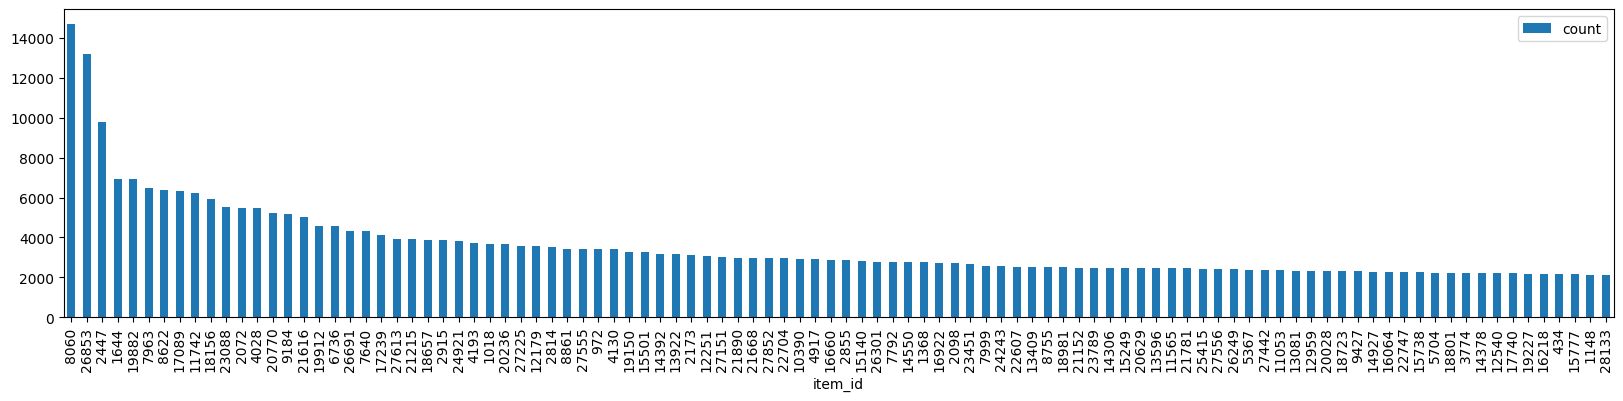

In [ ]:
most_consumed_items.toPandas().plot.bar(x="item_id",figsize=(20,4))

In [ ]:
DATASET_PATH ='./datasets/dressipi_recsys2022_dataset'

purchased_items = os.path.join(DATASET_PATH,"train_purchases.csv")
data = spark.read.format("csv").option("header", "true").load(purchased_items)

most_purchased_items = data.groupBy("item_id").agg(count(col="item_id").alias("count_purchased")).sort(col("count_purchased").desc())#.limit(100)

<Axes: xlabel='item_id'>

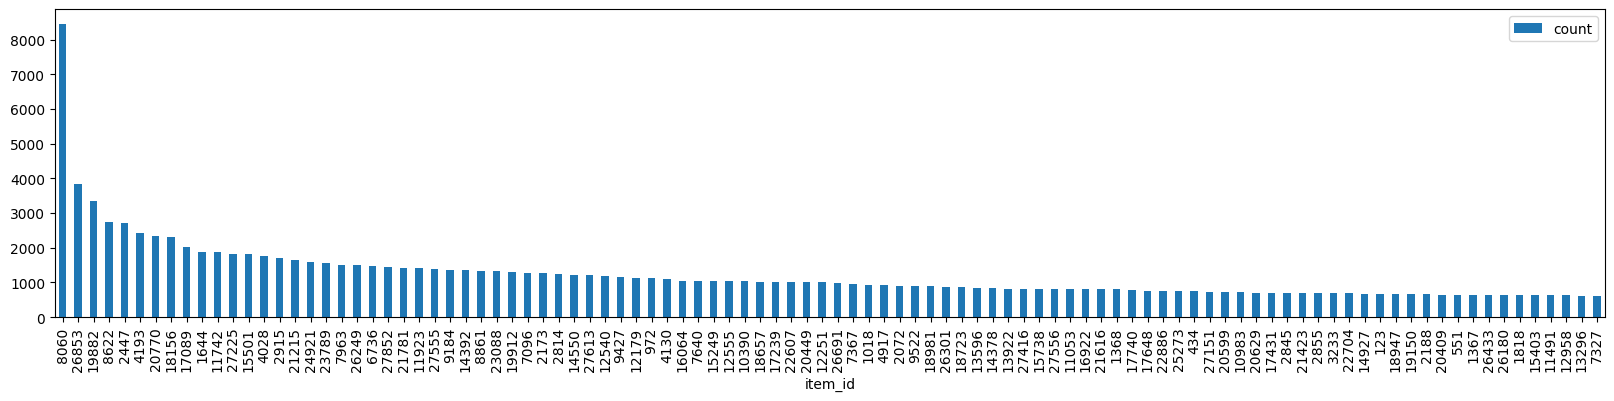

In [ ]:
most_purchased_items.toPandas().plot.bar(x="item_id",figsize=(20,4))

In [ ]:
# Join the most seen and most purchased dataframes
# Plot to compare 
joined_df = most_consumed_items\
            .alias("s")\
            .join(most_purchased_items.alias("p"),\
                  most_consumed_items.item_id == most_purchased_items.item_id,"inner" )\
            .select("s.item_id","s.count_seen","p.count_purchased")\
            .orderBy(col("count_seen").desc())

<Axes: xlabel='item_id'>

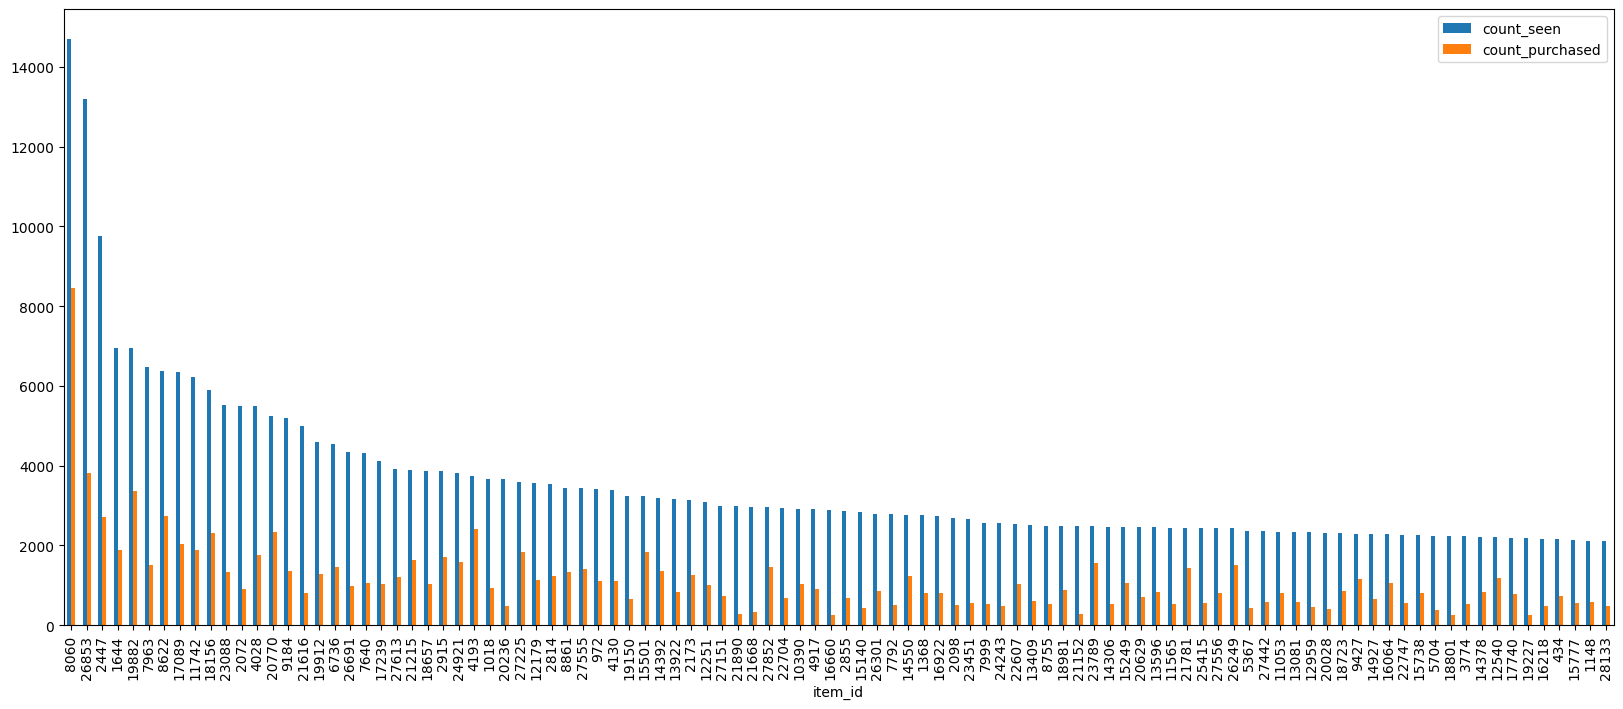

In [ ]:
joined_df.limit(100).toPandas().plot.bar(x="item_id",y=["count_seen","count_purchased"],figsize=(20,8))

## Variance in session length

In [ ]:
DATASET_PATH ='./datasets/dressipi_recsys2022_dataset'

consumed_items = os.path.join(DATASET_PATH,"train_sessions.csv")
data = spark.read.format("csv").option("header", "true").load(consumed_items)

n_consumed_items = data.groupBy("session_id").agg(count(col="item_id").alias("n_consumed_items")).sort(col("n_consumed_items").desc())#.limit(100)

In [ ]:
#n_consumed_items.toPandas().plot.bar(x="session_id",figsize=(20,4))
from pyspark.sql.functions import count

n_consumed_items.select(count(n_consumed_items.session_id)).show()

+-----------------+
|count(session_id)|
+-----------------+
|          1000000|
+-----------------+



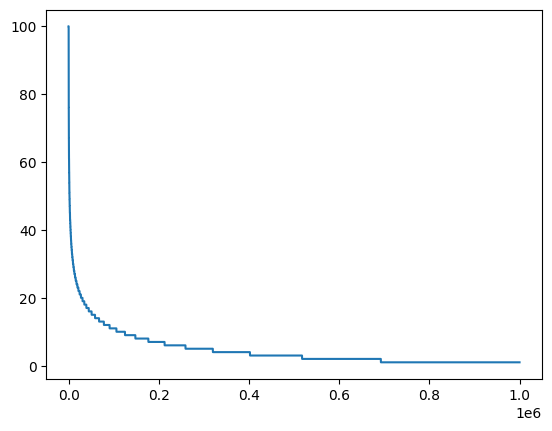

In [ ]:
x = range(1000000)
y = n_consumed_items.toPandas().n_consumed_items.values

plt.plot(x,y)

## Common Features between Consumed Items in a session and purchased items

In [ ]:
from collections import defaultdict


def accumulate_features_occurence(item_ids,features_path,spark_session):
  # TODO take the full session
  # accumulate the features for all the items
  
  # Load the features
  features = spark_session.read.format("csv").option("header", "true").load(features_path)
  # create a default dictionary for the features
  features_count = {key:0 for key in range(1,74)}
  
  for item_id in item_ids:
    
    rows = features.filter(
        features.item_id == item_id
    ).collect()

    # accumulate features count
    for row in rows:
      features_count[int(row.feature_category_id)] += 1/(len(item_ids))
  
  return features_count

def show_barplot(x,y):
  plt.plot.bar(x=x,y=y,figsize=(18,8))

### Case of Long sessions (100 consumed items)

In [ ]:
DATASET_PATH ='./datasets/dressipi_recsys2022_dataset'
features_path = os.path.join(DATASET_PATH,"item_features.csv")

consumed_items_p = os.path.join(DATASET_PATH,"train_sessions.csv")
consumed_items = spark.read.format("csv").option("header", "true").load(consumed_items_p)

n_consumed_items = consumed_items.groupBy("session_id").agg(count(col="item_id").alias("n_consumed_items"))

c_long_sessions = n_consumed_items.select(['n_consumed_items', 'session_id'])\
                .where("n_consumed_items == 100")\
                .limit(4)


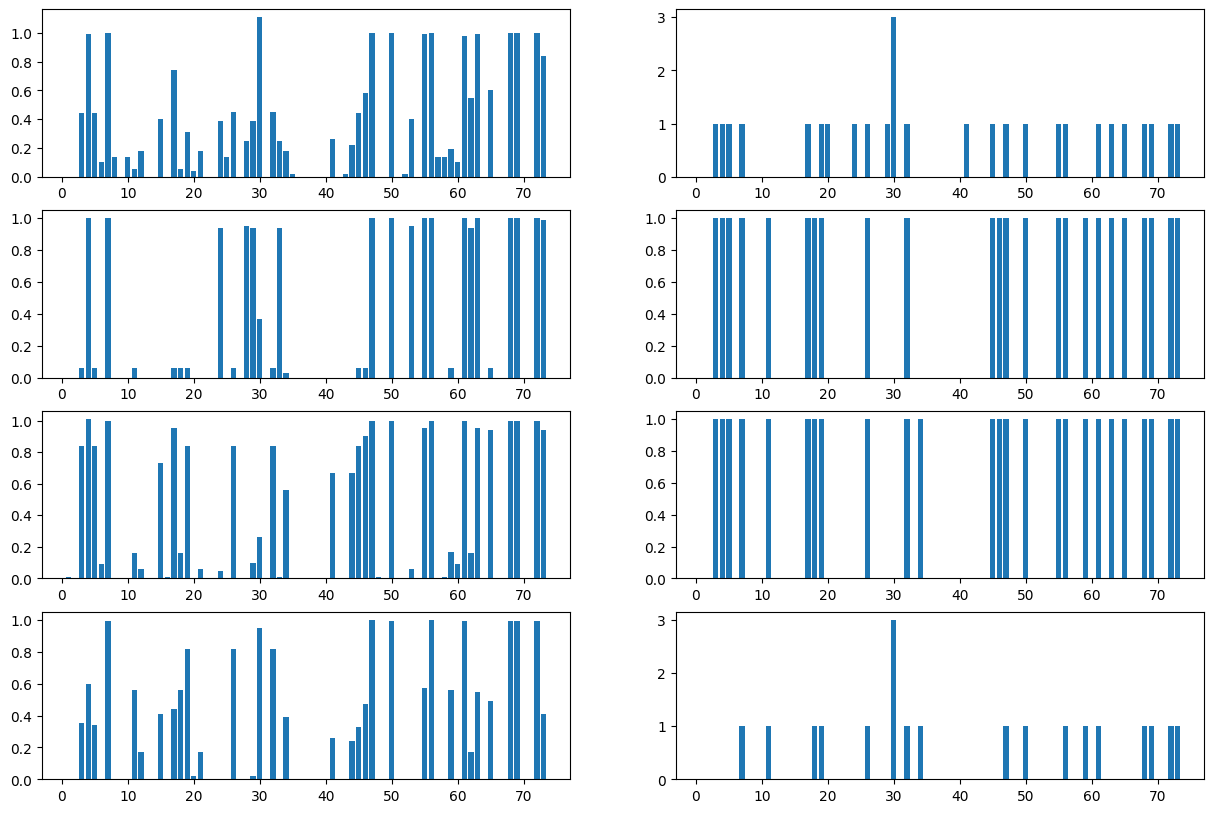

In [ ]:
purchased_items = os.path.join(DATASET_PATH,"train_purchases.csv")
purchased_items = spark.read.format("csv").option("header", "true").load(purchased_items)
p_long_sessions = purchased_items.alias("p")\
                .join(c_long_sessions.alias("s"),\
                    c_long_sessions.session_id == purchased_items.session_id,"inner" )\
                .select(["s.session_id","p.item_id"])\
                .collect()

long_sessions = [row.session_id for row in p_long_sessions]
p_items = [row.item_id for row in p_long_sessions]

features_path = os.path.join(DATASET_PATH,"item_features.csv")

fig, axes = plt.subplots(len(long_sessions),2,figsize=(15,14))

for i,session_id in enumerate(long_sessions):
  c_items = consumed_items.where(consumed_items.session_id == session_id)\
                                  .sort(col("date").asc())\
                                  .select('item_id')\
                                  .collect()
  c_items = [row.item_id for row in c_items]
  c_counts = accumulate_features_occurence(c_items,features_path,spark_session=spark)
  p_counts = accumulate_features_occurence([p_items[i]],features_path,spark_session=spark)

  axes[i,0].bar(c_counts.keys(),c_counts.values())
  axes[i,0].set_title(f'Features of items consumed in session: {session_id}')
  axes[i,1].bar(c_counts.keys(),p_counts.values(),color="orange")
  axes[i,1].set_title(f'Features of purchased item {p_items[i]} in session: {session_id}')
  

### Case of medium sessions (~ 20 consumed items)

In [ ]:
# OR n_consumed_items == 20  OR n_consumed_items == 5 OR n_consumed_items == 1
c_medium_sessions = n_consumed_items.select(['n_consumed_items', 'session_id'])\
                .where("n_consumed_items == 20")\
                .limit(4)

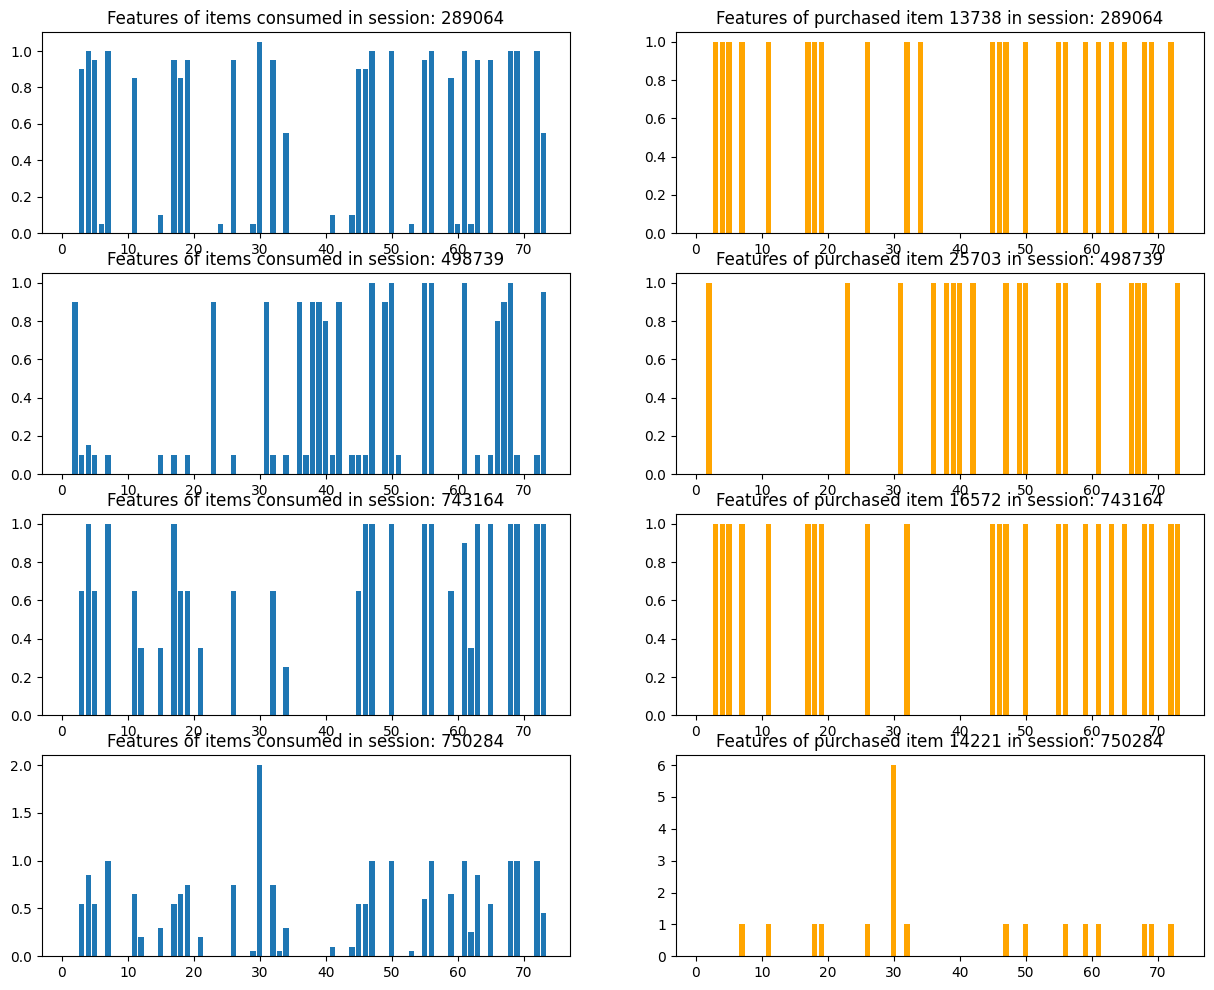

In [ ]:
purchased_items = os.path.join(DATASET_PATH,"train_purchases.csv")
purchased_items = spark.read.format("csv").option("header", "true").load(purchased_items)
p_medium_sessions = purchased_items.alias("p")\
                .join(c_medium_sessions.alias("s"),\
                    c_medium_sessions.session_id == purchased_items.session_id,"inner" )\
                .select(["s.session_id","p.item_id"])\
                .collect()

medium_sessions = [row.session_id for row in p_medium_sessions]
p_items = [row.item_id for row in p_medium_sessions]

features_path = os.path.join(DATASET_PATH,"item_features.csv")

fig, axes = plt.subplots(len(medium_sessions),2,figsize=(15,12))

for i,session_id in enumerate(medium_sessions):
  c_items = consumed_items.where(consumed_items.session_id == session_id)\
                                  .sort(col("date").asc())\
                                  .select('item_id')\
                                  .collect()
  c_items = [row.item_id for row in c_items]
  c_counts = accumulate_features_occurence(c_items,features_path,spark_session=spark)
  p_counts = accumulate_features_occurence([p_items[i]],features_path,spark_session=spark)

  axes[i,0].bar(c_counts.keys(),c_counts.values())
  axes[i,0].set_title(f'Features of items consumed in session: {session_id}')
  axes[i,1].bar(c_counts.keys(),p_counts.values(),color="orange")
  axes[i,1].set_title(f'Features of purchased item {p_items[i]} in session: {session_id}')
  

### Case of short sessions (~ 5 consumed items)

In [ ]:
c_short_sessions = n_consumed_items.select(['n_consumed_items', 'session_id'])\
                .where("n_consumed_items == 5")\
                .limit(4)

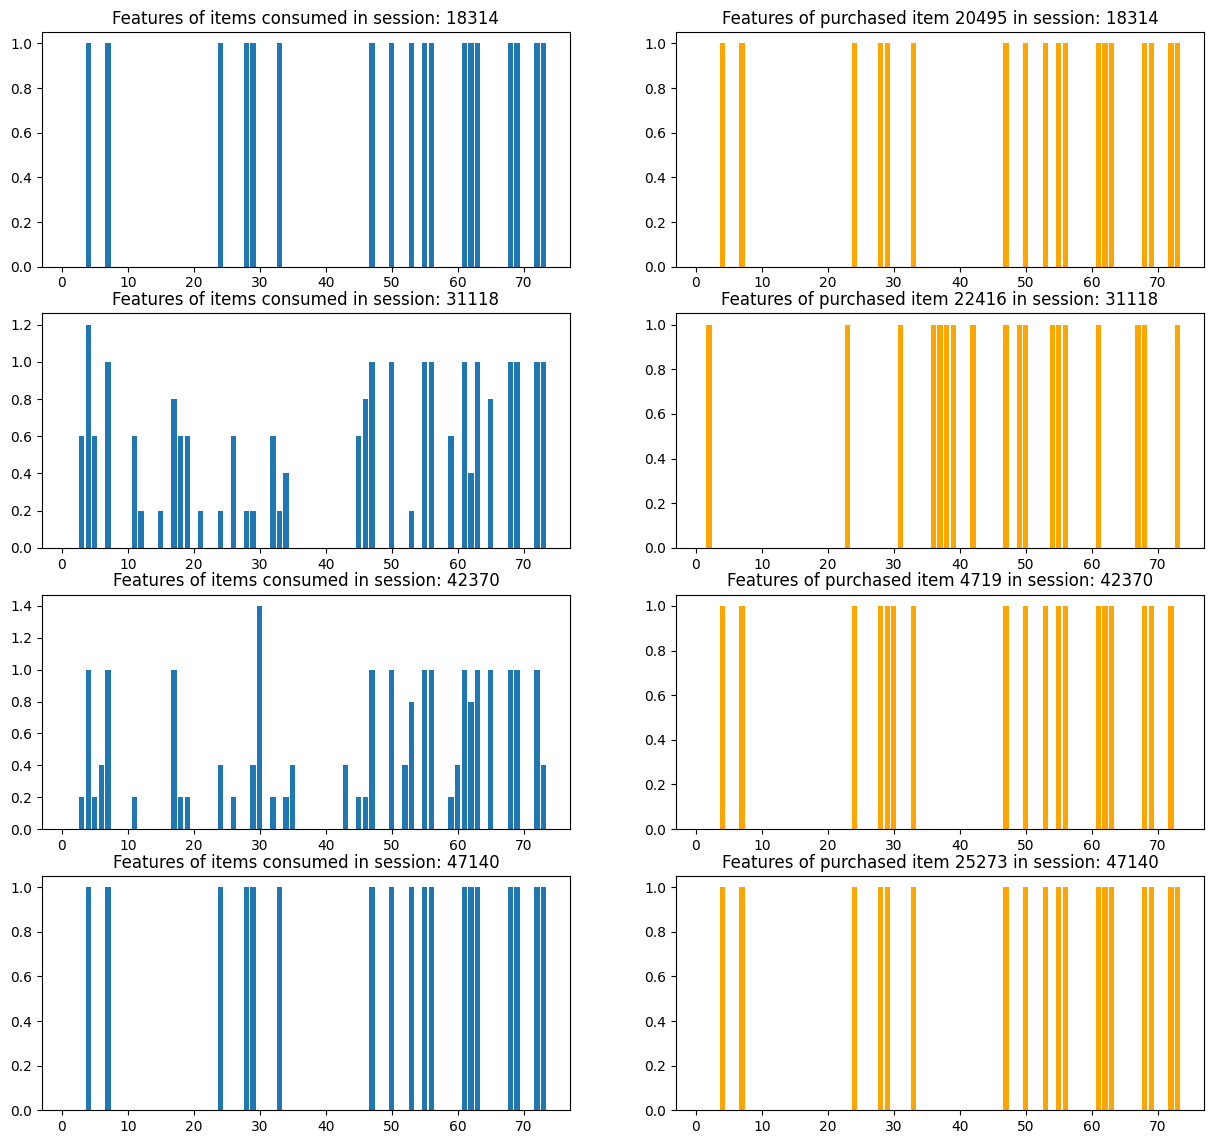

In [ ]:
purchased_items = os.path.join(DATASET_PATH,"train_purchases.csv")
purchased_items = spark.read.format("csv").option("header", "true").load(purchased_items)
p_short_sessions = purchased_items.alias("p")\
                .join(c_short_sessions.alias("s"),\
                    c_short_sessions.session_id == purchased_items.session_id,"inner" )\
                .select(["s.session_id","p.item_id"])\
                .collect()

short_sessions = [row.session_id for row in p_short_sessions]
p_items = [row.item_id for row in p_short_sessions]

features_path = os.path.join(DATASET_PATH,"item_features.csv")

fig, axes = plt.subplots(len(short_sessions),2,figsize=(15,14))

for i,session_id in enumerate(short_sessions):
  c_items = consumed_items.where(consumed_items.session_id == session_id)\
                                  .sort(col("date").asc())\
                                  .select('item_id')\
                                  .collect()
  c_items = [row.item_id for row in c_items]
  c_counts = accumulate_features_occurence(c_items,features_path,spark_session=spark)
  p_counts = accumulate_features_occurence([p_items[i]],features_path,spark_session=spark)

  axes[i,0].bar(c_counts.keys(),c_counts.values())
  axes[i,0].set_title(f'Features of items consumed in session: {session_id}')
  axes[i,1].bar(c_counts.keys(),p_counts.values(),color="orange")
  axes[i,1].set_title(f'Features of purchased item {p_items[i]} in session: {session_id}')
  

### Case of Nano sessions (1 consumed item)

In [ ]:
c_nano_sessions = n_consumed_items.select(['n_consumed_items', 'session_id'])\
                .where("n_consumed_items == 1")\
                .limit(4) 

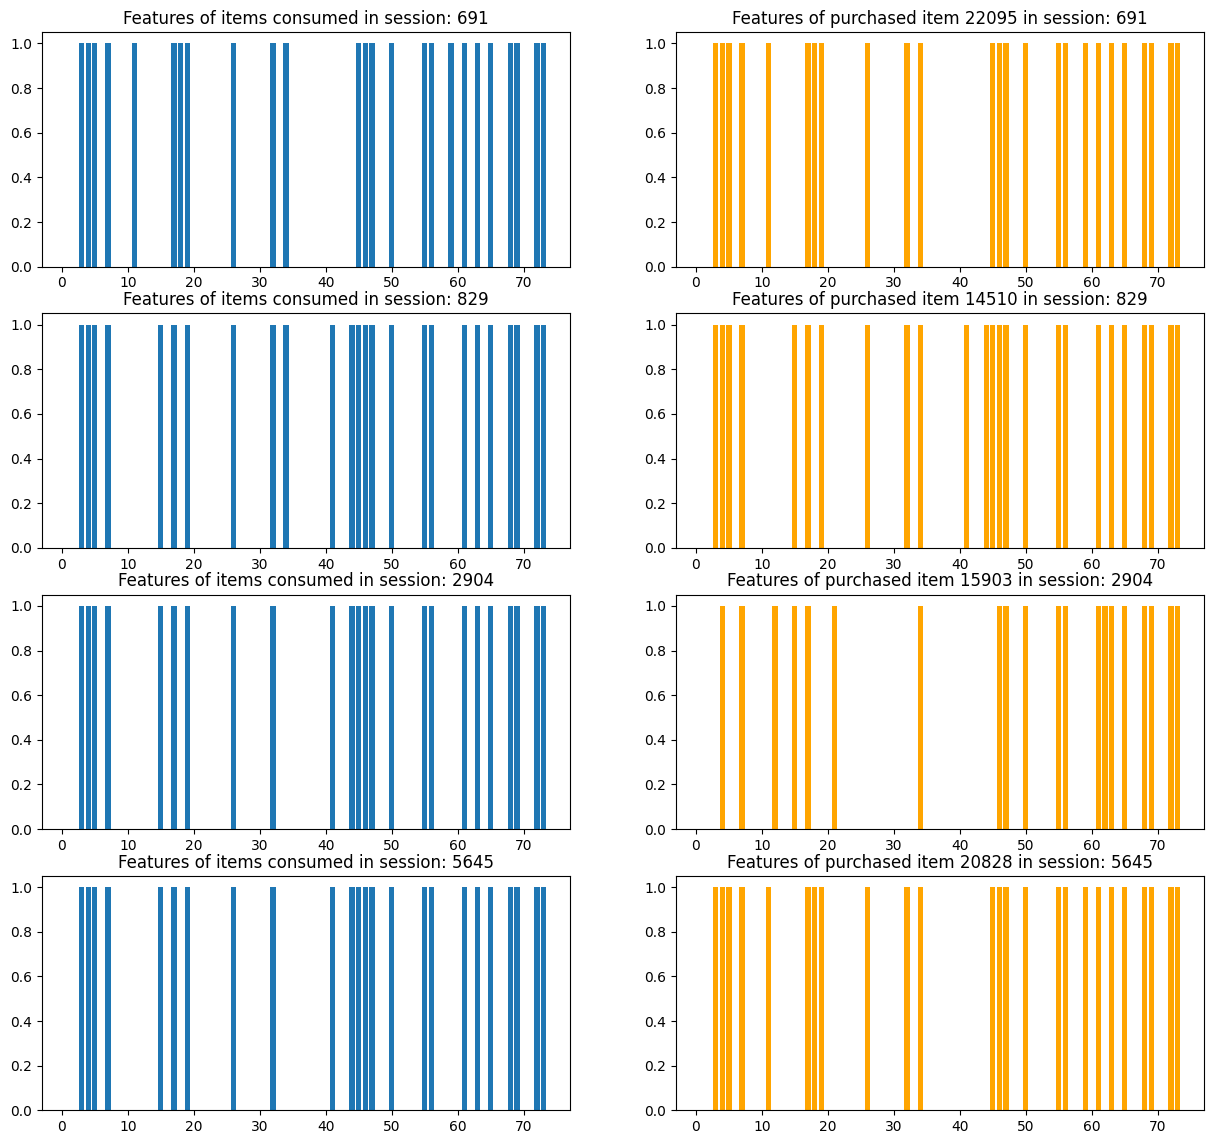

In [ ]:
purchased_items = os.path.join(DATASET_PATH,"train_purchases.csv")
purchased_items = spark.read.format("csv").option("header", "true").load(purchased_items)
p_nano_sessions = purchased_items.alias("p")\
                .join(c_nano_sessions.alias("s"),\
                    c_nano_sessions.session_id == purchased_items.session_id,"inner" )\
                .select(["s.session_id","p.item_id"])\
                .collect()

nano_sessions = [row.session_id for row in p_nano_sessions]
p_items = [row.item_id for row in p_nano_sessions]

features_path = os.path.join(DATASET_PATH,"item_features.csv")

fig, axes = plt.subplots(len(nano_sessions),2,figsize=(15,14))

for i,session_id in enumerate(nano_sessions):
  c_items = consumed_items.where(consumed_items.session_id == session_id)\
                                  .sort(col("date").asc())\
                                  .select('item_id')\
                                  .collect()
  c_items = [row.item_id for row in c_items]
  c_counts = accumulate_features_occurence(c_items,features_path,spark_session=spark)
  p_counts = accumulate_features_occurence([p_items[i]],features_path,spark_session=spark)

  axes[i,0].bar(c_counts.keys(),c_counts.values())
  axes[i,0].set_title(f'Features of items consumed in session: {session_id}')
  axes[i,1].bar(c_counts.keys(),p_counts.values(),color="orange")
  axes[i,1].set_title(f'Features of purchased item {p_items[i]} in session: {session_id}')
  